# Example: looking at DPC data


Start tdmq services:

```
docker-compose -f docker/docker-compose.yml up -d

```

Configure backend:
```
docker run --rm --network docker_default --entrypoint s3cmd  tdmproject/dpc_ingestor  --no-ssl --host=minio:9000 --host-bucket= --access_key=tdm-user --secret_key=tdm-user-s3 mb s3://firstbucket
```

Ingest data:

```
docker run --rm --network docker_default   tdmproject/dpc_ingestor -u http://web:8000/api/v0.0 temperature
```





In [1]:
import logging
logging.basicConfig(level=logging.INFO)
import numpy as np
from tdmq.client import Client, set_log_level
set_log_level(logging.DEBUG)

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

INFO:matplotlib.font_manager:Generating new fontManager, this may take some time...


In [3]:
c = Client('http://web:8000/api/v0.0')

DEBUG:tdmq.client.client:New tdmq client object for http://web:8000/api/v0.0


In [4]:
srcs = c.find_sources({'id': "dpc/meteo-temp-mosaic/v0"})
assert len(srcs) > 0
s = srcs[0]

DEBUG:tdmq.client.client:Service sent the following info: 
{'tiledb': {'config': {'vfs.s3.aws_access_key_id': 'tdm-user', 'vfs.s3.aws_secret_access_key': 'tdm-user-s3', 'vfs.s3.endpoint_override': 'minio:9000', 'vfs.s3.region': '', 'vfs.s3.scheme': 'http', 'vfs.s3.use_multipart_upload': 'false', 'vfs.s3.use_virtual_addressing': 'false', 'vfs.s3.verify_ssl': 'false'}, 'storage.root': 's3://firstbucket/'}, 'version': '0.1'}
INFO:tdmq.client.client:Configured TileDB context
DEBUG:tdmq.client.client:	 tiledb_storage_root: s3://firstbucket/
DEBUG:tdmq.client.client:	 tiledb_config:
Parameter                            | Value                   
------------------------------------ | ------------------------
config.env_var_prefix                | 'TILEDB_'               
rest.http_compressor                 | 'any'                   
rest.server_address                  | 'https://api.tiledb.com'
rest.server_serialization_format     | 'CAPNP'                 
sm.check_coord_dups             

In [5]:
ts = s.timeseries()

DEBUG:tdmq.client.client:get_timeseries(7ccafc31-aa71-5cef-9b47-a2cbd72b9e79, {})


In [6]:
(time, data) = ts[4]

In [7]:
temp = data['TEMP'] * (data['TEMP'] > -9000.0)

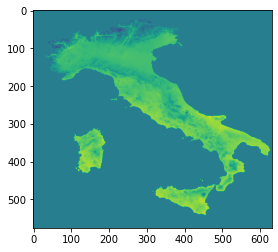

In [8]:
plt.imshow(temp)

In [9]:
(_, sardinia) = ts[4, 300:440, 100:200]

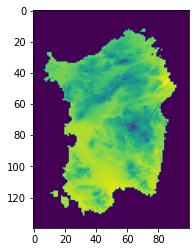

In [10]:
plt.imshow(sardinia['TEMP'] * (sardinia['TEMP'] > -9000.0))

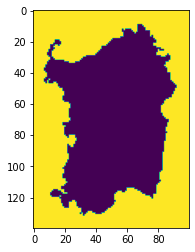

In [11]:
sea = sardinia['TEMP'] == 0
plt.imshow(sea)

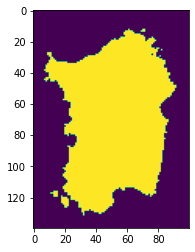

In [12]:
land = sardinia['TEMP'] > 0
plt.imshow(land)

In [13]:
(time, data) = ts[:, 300:440, 100:200]

In [14]:
temp = data['TEMP'] * (data['TEMP'] > -9000)

In [15]:
max_temp = temp.reshape(len(time), -1).max(axis=1)
min_temp = (temp + 200 * (temp == 0.0)).reshape(len(time), -1).min(axis=1)

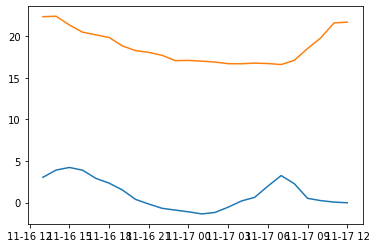

In [16]:
plt.plot(time, np.stack([min_temp, max_temp], axis=1))

In [17]:
good_frames_selector = temp.reshape(len(time), -1).max(axis=1) > 0

In [18]:
good_time = time[good_frames_selector]
good_temp = temp[good_frames_selector]

In [19]:
max_temp = good_temp.reshape(len(good_time), -1).max(axis=1)
min_temp = (good_temp + 200 * (good_temp == 0.0)).reshape(len(good_time), -1).min(axis=1)

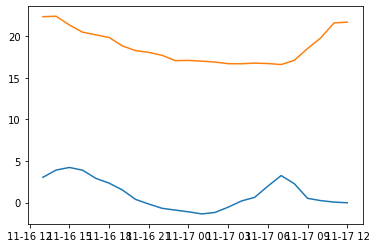

In [20]:
plt.plot(good_time, np.stack([min_temp, max_temp], axis=1))